In [4]:
import pandas as pd
from nltk.corpus import stopwords
from gensim import corpora, models, similarities, utils, matutils

In [5]:
from sklearn import tree, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import LogisticRegression, SVM, Perceptron
from libact.models import SklearnAdapter
from libact.labelers import IdealLabeler
from libact.query_strategies import RandomSampling, UncertaintySampling,HintSVM, QueryByCommittee
from libact.query_strategies.multiclass import EER

In [7]:
import matplotlib.pyplot as plt
import copy
import numpy as np

In [8]:
df_all_topics = pd.read_csv('pubmed_data', usecols= ['pid', 'title', 'abstract', 'topic_id', 'sr_title', 'rel'])

In [9]:
df_all_topics.head()

,pid,title,abstract,topic_id,sr_title,rel
0,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD011548,Ultrasound versus liver function tests for dia...,0
1,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD011549,Endoscopic ultrasound versus magnetic resonanc...,0
2,3903849,[Nonvisualization of the gallbladder lumen by ...,Out of 12 000 sonographic examinations of the ...,CD010339,Endoscopic retrograde cholangiopancreatography...,0
3,1559484,Cholangioscopy.,NaN,CD011548,Ultrasound versus liver function tests for dia...,0
4,1559484,Cholangioscopy.,NaN,CD011549,Endoscopic ultrasound versus magnetic resonanc...,0


In [50]:
 df_all_topics[df_all_topics['topic_id'] == 'CD009944']

,pid,title,abstract,topic_id,sr_title,rel
2931,10777153,Recent advances in endoscopic ultrasonography.,Endoscopic ultrasonography is recognized as an...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
3733,8497780,[Endosonography in oncology of the upper gastr...,Based on our own experience and on data from t...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
14281,20547601,Endoscopic ultrasound: a review of current dia...,Endoscopic ultrasound (EUS) has become importa...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
20091,18810677,[Miniprobe EUS].,"With the advent of flexible, high-frequency ca...",CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
22953,14963789,[Requirements and recommendations for performi...,For improvement of quality the working group o...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
24461,8675534,Endoscopic ultrasound: improving GI diagnosis.,"At present, the technique--which incorporates ...",CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
25348,12552408,[Glomus tumour of the stomach. A case report].,Glomus tumours are benign neoplasms that usual...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
27132,18317657,[I Brazilian consensus of endoscopic ultrasono...,"In the last 20 years, several papers have focu...",CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
39389,16429349,Endoscopic ultrasonography.,NaN,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0
50246,17443300,[Endosonography of the gastrointestinal tract].,The clinical value of endosonography (EUS) in ...,CD009944,Diagnostic accuracy of endoscopic ultrasonogra...,0


In [10]:
def get_data_by_topic(topic_id, df_all_topics):
    df_specific_topic = df_all_topics[df_all_topics['topic_id'] == topic_id]
    #primero creamos el dicionario    
    stop_words = stopwords.words('english')
    dictionary = corpora.Dictionary()
    for index, row in df_specific_topic.iterrows():
        if type(row['abstract']) == str:  # revisamos si tenemos el abstract (no estan todos)
            title = list(filter(lambda x : x not in stop_words, utils.tokenize(row['title'], lowercase = True)))
            abstract = list(filter(lambda x : x not in stop_words, utils.tokenize(row['abstract'], lowercase = True)))
            dictionary.add_documents([title,abstract]) 
    #luego transformamos las palabras segun el diccionario
    labels = []
    corpus = []
    for index, row in df_specific_topic.iterrows():
        if type(row['abstract']) == str: # revisamos si tenemos el abstract (no estan todos)
            title = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['title'], lowercase=True))) 
            abstract = list(filter(lambda x : x  not in stop_words, utils.tokenize(row['abstract'], lowercase=True)))
            corpus.append(dictionary.doc2bow(title+abstract))
            labels.append(row['rel'])
    print("dictionary len: {0}".format(len(dictionary)))       
    scipy_csc_matrix = matutils.corpus2dense(corpus, len(dictionary))
    scipy_csc_matrix_t = scipy_csc_matrix.transpose()        
    return labels, scipy_csc_matrix_t

In [32]:
topic_id = 'CD009944'
labels, scipy_csc_matrix_t = get_data_by_topic(topic_id, df_all_topics)

dictionary len: 6185


In [33]:
#testing with a simple model to see if works
clf = BernoulliNB()
scores1 = cross_val_score(clf, scipy_csc_matrix_t, labels, cv=5, scoring=('accuracy')).mean()
print (scores1)

0.887194591727


In [11]:
def split_train_test(X, y, test_size, n_labeled):

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds

In [12]:
def run(trn_ds, X_test, y_test, lbr, model, qs, quota):
    Acurracy_out, F1_macro_out, presicion_out, recall_out, matthews_corrcoef  = [], [], [], [], []

    for _ in range(quota):
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        y_pred = model.predict(X_test)
        Acurracy_out = np.append(Acurracy_out, metrics.accuracy_score(y_test, y_pred))
        F1_macro_out = np.append(F1_macro_out, metrics.f1_score(y_test, y_pred, average='macro'))
        presicion_out = np.append(presicion_out, metrics.precision_score(y_test, y_pred, pos_label= 1, average='binary'))
        recall_out = np.append(recall_out, metrics.recall_score(y_test, y_pred, pos_label=1, average='binary'))
        matthews_corrcoef = np.append(matthews_corrcoef, metrics.matthews_corrcoef(y_test, y_pred))
        

    return  Acurracy_out, F1_macro_out, presicion_out, recall_out, matthews_corrcoef

In [53]:
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 10   # number of samples that are initially labeled

# Load dataset
trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds = \
     split_train_test(scipy_csc_matrix_t, labels, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query


model = LogisticRegression()
qs = RandomSampling(trn_ds)
Lg_R_Acurracy, Lg_R_F1_macro, Lg_R_presicion, Lg_R_recall, Lg_R_matthews_corrcoef = \
run(trn_ds, X_test, y_test, lbr, model, qs, quota)

In [54]:
model = LogisticRegression()
qs2 = UncertaintySampling(
         trn_ds2, # Dataset object
         model=LogisticRegression()
     )
Lg_U_Acurracy, Lg_U_F1_macro, Lg_U_presicion, Lg_U_recall, Lg_U_matthews_corrcoef = \
run(trn_ds2, X_test, y_test, lbr, model, qs2, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


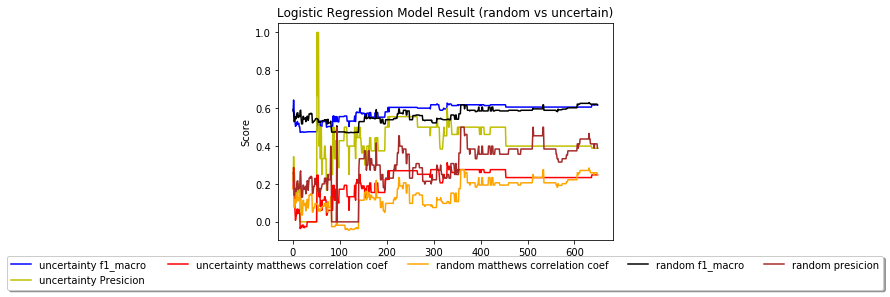

In [55]:
query_num = np.arange(1, quota + 1)
#plt.plot(query_num, Lg_U_Acurracy, 'm', label='uncertainty Acurracy')
plt.plot(query_num, Lg_U_F1_macro, 'blue', label='uncertainty f1_macro')
plt.plot(query_num, Lg_U_presicion, 'y', label='uncertainty Presicion ')
plt.plot(query_num, Lg_U_matthews_corrcoef, 'red', label='uncertainty matthews correlation coef')
plt.plot(query_num, Lg_R_matthews_corrcoef, 'orange', label='random matthews correlation coef')
#plt.plot(query_num, Lg_R_Acurracy, 'g', label='random Acurracy')
plt.plot(query_num, Lg_R_F1_macro, 'k', label='random f1_macro')
plt.plot(query_num, Lg_R_presicion, 'brown', label='random presicion')

plt.xlabel('Number of Queries')
plt.ylabel('Score')
plt.title('Logistic Regression Model Result (random vs uncertain)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

In [56]:
model = LogisticRegression()
qs3 = QueryByCommittee(
         trn_ds3, # Dataset object
         models=[
             LogisticRegression(),
             LogisticRegression(C=1.0),
             LogisticRegression(C=0.1),
         ],
     )
Lg_C_Acurracy, Lg_C_F1_macro, Lg_C_presicion, Lg_C_recall, Lg_C_matthews_corrcoef = \
run(trn_ds3, X_test, y_test, lbr, model, qs3, quota)

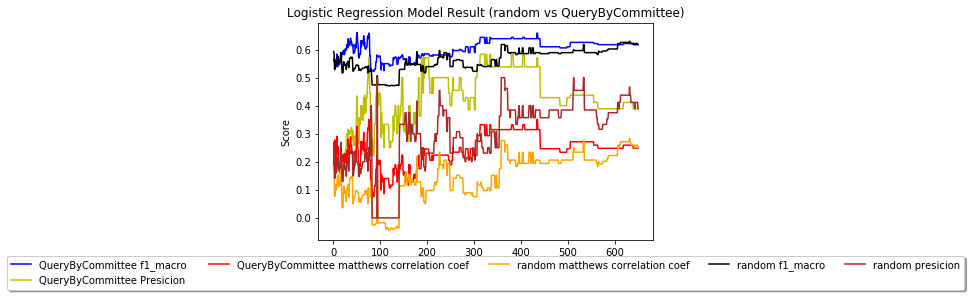

In [57]:
query_num = np.arange(1, quota + 1)
#plt.plot(query_num, Lg_U_Acurracy, 'm', label='uncertainty Acurracy')
plt.plot(query_num, Lg_C_F1_macro, 'blue', label='QueryByCommittee f1_macro')
plt.plot(query_num, Lg_C_presicion, 'y', label='QueryByCommittee Presicion ')
plt.plot(query_num, Lg_C_matthews_corrcoef, 'red', label='QueryByCommittee matthews correlation coef')
plt.plot(query_num, Lg_R_matthews_corrcoef, 'orange', label='random matthews correlation coef')
#plt.plot(query_num, Lg_R_Acurracy, 'g', label='random Acurracy')
plt.plot(query_num, Lg_R_F1_macro, 'k', label='random f1_macro')
plt.plot(query_num, Lg_R_presicion, 'brown', label='random presicion')

plt.xlabel('Number of Queries')
plt.ylabel('Score')
plt.title('Logistic Regression Model Result (random vs QueryByCommittee)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

In [87]:
topic_id = 'CD007394'
labels, scipy_csc_matrix_t = get_data_by_topic(topic_id, df_all_topics)

dictionary len: 15497


In [103]:
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 10   # number of samples that are initially labeled

# Load dataset
trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds = \
     split_train_test(scipy_csc_matrix_t, labels, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
trn_ds4 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query


model = LogisticRegression()
qs = RandomSampling(trn_ds)
Lg_R_Acurracy, Lg_R_F1_macro, Lg_R_presicion, Lg_R_recall, Lg_R_matthews_corrcoef = \
run(trn_ds, X_test, y_test, lbr, model, qs, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [104]:
model = LogisticRegression()
qs2 = UncertaintySampling(
         trn_ds2, # Dataset object
         model=LogisticRegression()
     )
Lg_U_Acurracy, Lg_U_F1_macro, Lg_U_presicion, Lg_U_recall, Lg_U_matthews_corrcoef = \
run(trn_ds2, X_test, y_test, lbr, model, qs2, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


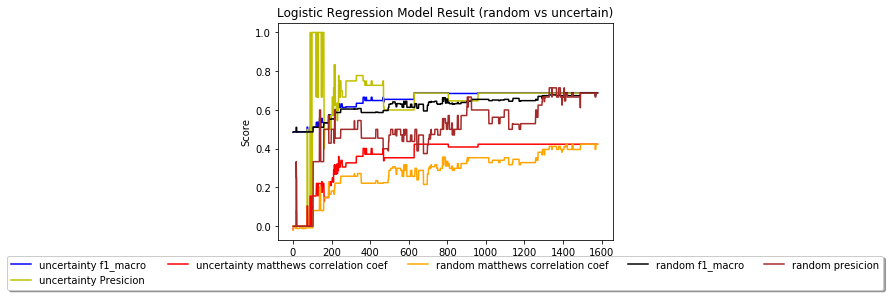

In [105]:
query_num = np.arange(1, quota + 1)
#plt.plot(query_num, Lg_U_Acurracy, 'm', label='uncertainty Acurracy')
plt.plot(query_num, Lg_U_F1_macro, 'blue', label='uncertainty f1_macro')
plt.plot(query_num, Lg_U_presicion, 'y', label='uncertainty Presicion ')
plt.plot(query_num, Lg_U_matthews_corrcoef, 'red', label='uncertainty matthews correlation coef')
plt.plot(query_num, Lg_R_matthews_corrcoef, 'orange', label='random matthews correlation coef')
#plt.plot(query_num, Lg_R_Acurracy, 'g', label='random Acurracy')
plt.plot(query_num, Lg_R_F1_macro, 'k', label='random f1_macro')
plt.plot(query_num, Lg_R_presicion, 'brown', label='random presicion')

plt.xlabel('Number of Queries')
plt.ylabel('Score')
plt.title('Logistic Regression Model Result (random vs uncertain)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

In [106]:
model = LogisticRegression()
qs3 = QueryByCommittee(
         trn_ds3, # Dataset object
         models=[
             LogisticRegression(),
             LogisticRegression(C=1.0),
             LogisticRegression(C=0.1),
         ],
     )
Lg_C_Acurracy, Lg_C_F1_macro, Lg_C_presicion, Lg_C_recall, Lg_C_matthews_corrcoef = \
run(trn_ds3, X_test, y_test, lbr, model, qs3, quota)

There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receiving only one label,re-sample the bag.
There is student receivi

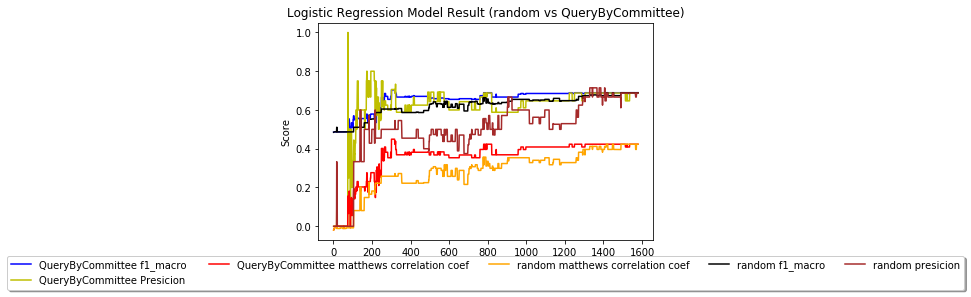

In [107]:
query_num = np.arange(1, quota + 1)
#plt.plot(query_num, Lg_U_Acurracy, 'm', label='uncertainty Acurracy')
plt.plot(query_num, Lg_C_F1_macro, 'blue', label='QueryByCommittee f1_macro')
plt.plot(query_num, Lg_C_presicion, 'y', label='QueryByCommittee Presicion ')
plt.plot(query_num, Lg_C_matthews_corrcoef, 'red', label='QueryByCommittee matthews correlation coef')
plt.plot(query_num, Lg_R_matthews_corrcoef, 'orange', label='random matthews correlation coef')
#plt.plot(query_num, Lg_R_Acurracy, 'g', label='random Acurracy')
plt.plot(query_num, Lg_R_F1_macro, 'k', label='random f1_macro')
plt.plot(query_num, Lg_R_presicion, 'brown', label='random presicion')

plt.xlabel('Number of Queries')
plt.ylabel('Score')
plt.title('Logistic Regression Model Result (random vs QueryByCommittee)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()

In [44]:
topic_id = 'CD008054'
labels, scipy_csc_matrix_t = get_data_by_topic(topic_id, df_all_topics)

dictionary len: 12391


In [45]:
test_size = 0.33    # the percentage of samples in the dataset that will be
# randomly selected and assigned to the test set
n_labeled = 50   # number of samples that are initially labeled

# Load dataset
trn_ds, X_test, y_test, y_train, fully_labeled_trn_ds = \
     split_train_test(scipy_csc_matrix_t, labels, test_size, n_labeled)
trn_ds2 = copy.deepcopy(trn_ds)
trn_ds3 = copy.deepcopy(trn_ds)
lbr = IdealLabeler(fully_labeled_trn_ds)

quota = len(y_train) - n_labeled    # number of samples to query


model = LogisticRegression()
qs = RandomSampling(trn_ds)
Lg_R_Acurracy, Lg_R_F1_macro, Lg_R_presicion, Lg_R_recall, Lg_R_matthews_corrcoef = \
run(trn_ds, X_test, y_test, lbr, model, qs, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [46]:
model = LogisticRegression()
qs2 = UncertaintySampling(
         trn_ds2, # Dataset object
         model=LogisticRegression()
     )
Lg_U_Acurracy, Lg_U_F1_macro, Lg_U_presicion, Lg_U_recall, Lg_U_matthews_corrcoef = \
run(trn_ds2, X_test, y_test, lbr, model, qs2, quota)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


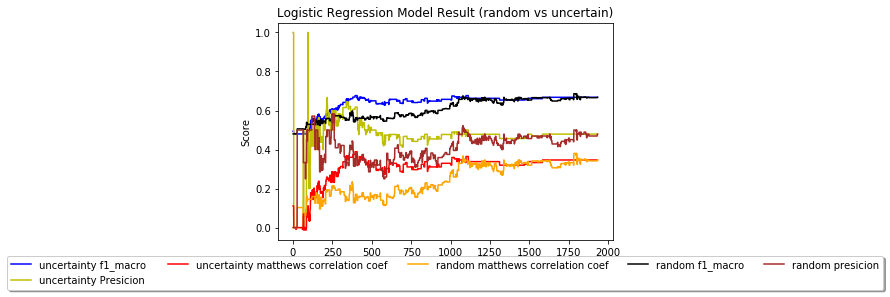

In [47]:
query_num = np.arange(1, quota + 1)
#plt.plot(query_num, Lg_U_Acurracy, 'm', label='uncertainty Acurracy')
plt.plot(query_num, Lg_U_F1_macro, 'blue', label='uncertainty f1_macro')
plt.plot(query_num, Lg_U_presicion, 'y', label='uncertainty Presicion ')
plt.plot(query_num, Lg_U_matthews_corrcoef, 'red', label='uncertainty matthews correlation coef')
plt.plot(query_num, Lg_R_matthews_corrcoef, 'orange', label='random matthews correlation coef')
#plt.plot(query_num, Lg_R_Acurracy, 'g', label='random Acurracy')
plt.plot(query_num, Lg_R_F1_macro, 'k', label='random f1_macro')
plt.plot(query_num, Lg_R_presicion, 'brown', label='random presicion')

plt.xlabel('Number of Queries')
plt.ylabel('Score')
plt.title('Logistic Regression Model Result (random vs uncertain)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.show()